In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
test_img=cv2.imread("test_images/test1.jpg")
test_car=cv2.imread("test_images/Car1.png")

In [3]:
notcar_list=["non-vehicles/Extras/*.png",
          "non-vehicles/GTI/*.png"]

car_list=["vehicles/GTI_Far/*.png",
          "vehicles/GTI_Left/*.png",
          "vehicles/GTI_MiddleClose/*.png",
          "vehicles/GTI_Right/*.png",
          "vehicles/KITTI_extracted/*.png"]

### Spatial Bins

Input Image Size :  (64, 64, 3)


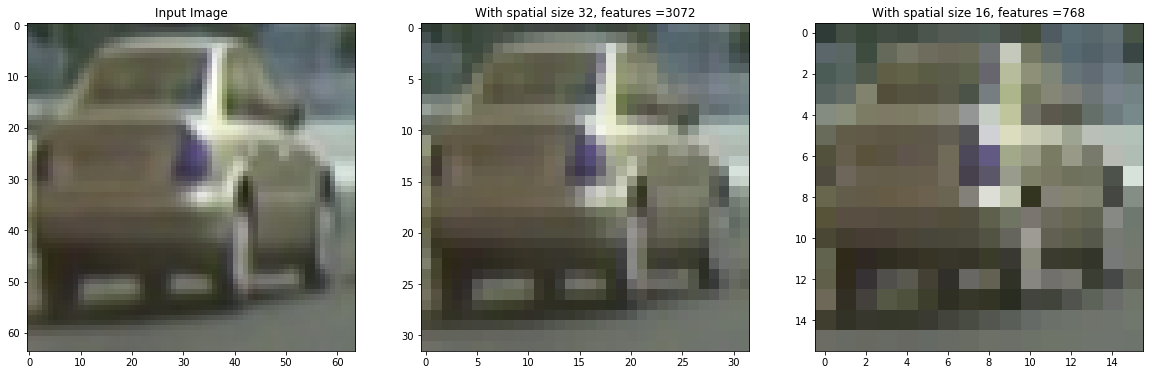

In [4]:
print("Input Image Size : ",test_car.shape)
fig,ax=plt.subplots(1,3,figsize=(20,20))
ax[0].set_title("Input Image")
ax[0].imshow(test_car)
ax[1].set_title("With spatial size 32, features ="+str(32*32*3))
ax[1].imshow(cv2.resize(test_car,(32,32)))
ax[2].set_title("With spatial size 16, features ="+str(16*16*3))
ax[2].imshow(cv2.resize(test_car,(16,16)))

In [5]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

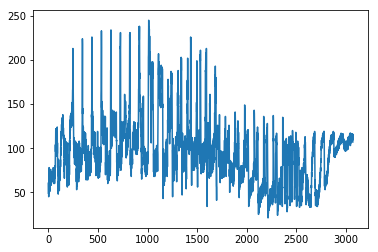

In [6]:
b=bin_spatial(test_car)
plt.plot(b)

### Color Histogram

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

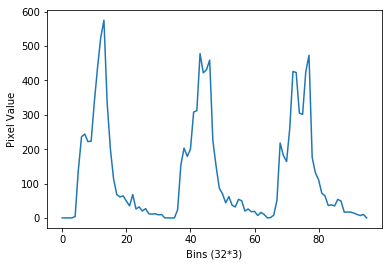

In [8]:
f=color_hist(test_car)
plt.plot(f)
plt.xlabel("Bins (32*3)")
plt.ylabel("Pixel Value")

### HOG Features

In [9]:
from skimage.feature import hog
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

(64, 64, 3)


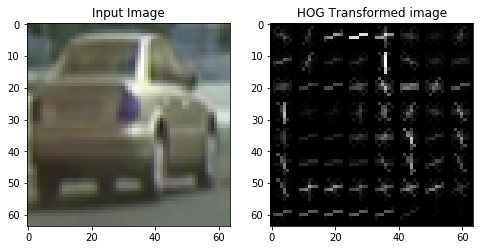

In [10]:
test_image=cv2.cvtColor(test_car,cv2.COLOR_BGR2YUV)
hog_features,hog_image=get_hog_features(test_image[:,:,0],vis=True)
print(test_car.shape)
fig,ax=plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(test_car)
ax[0].set_title("Input Image")
ax[1].imshow(hog_image,cmap='gray')
ax[1].set_title("HOG Transformed image")

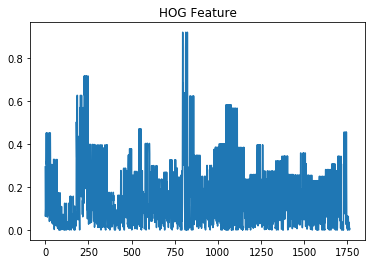

In [11]:
plt.plot(hog_features)
plt.title("HOG Feature")

### Extract Features 

In [12]:
def extract_features(image, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=16,spatial_feat=True, hist_feat=True, hog_feat=True):
    # Changing color space
    if color_space != 'BGR':
        if color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else:
        feature_image = np.copy(image)
    
    file_feature=[]
    if spatial_feat == True:
        file_feature.append(bin_spatial(feature_image,size=spatial_size))
    
    if hist_feat == True:
        file_feature.append(color_hist(feature_image, nbins=hist_bins))
    
    if hog_feat == True:
        file_feature.append(get_hog_features(feature_image[:,:,0]))
    
    return np.concatenate(file_feature).astype(np.float64)

Feature length = 2580


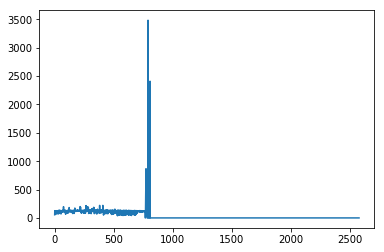

In [13]:
Flag_hist= True
Flag_hog = True
Flag_spatial = True
Color_Space="YUV"

test_features=extract_features(test_car,color_space=Color_Space,hist_feat=Flag_hist, hog_feat=Flag_hog,
                               spatial_feat=Flag_spatial)

print("Feature length =",len(test_features))
plt.plot(test_features)

In [15]:
import glob

# Extract Car Features
car_features=[]
for car_images in car_list:
    car_images=glob.glob(car_images)
    for img_name in car_images:
        img=cv2.imread(img_name)
        car_features.append(extract_features(img,color_space=Color_Space,
                                             hist_feat=Flag_hist,hog_feat=Flag_hog,spatial_feat=Flag_spatial))
print("Total car images =",len(car_features))  

# Extract Not Car Features
notcar_features=[]
for notcar_images in notcar_list:
    notcar_images=glob.glob(notcar_images)
    for img_name in notcar_images:
        img=cv2.imread(img_name)
        notcar_features.append(extract_features(img,color_space=Color_Space,
                                                hist_feat=Flag_hist,hog_feat=Flag_hog,spatial_feat=Flag_spatial))
print("Total non car images =",len(notcar_features))  

Total car images = 8792
Total non car images = 8968


In [16]:
# Creating input & output vectors
features=np.vstack((car_features,notcar_features)).astype(np.float64)
labels=np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))
print("Total input :",len(features))
print("Total features per input :",len(features[0]))
print("Total labels :",len(labels))

Total input : 17760
Total features per input : 2580
Total labels : 17760


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, shuffle=True,random_state=42)


### Normalization

In [18]:
from sklearn.preprocessing import StandardScaler

scal = StandardScaler().fit(features)
X_train_Scaled = scal.transform(X_train)
X_test_Scaled = scal.transform(X_test)

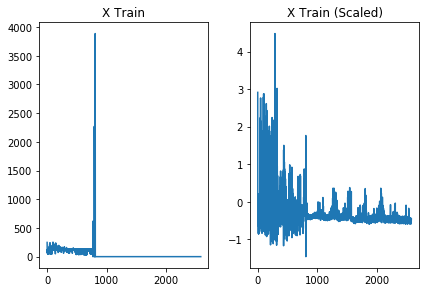

In [19]:
fig,ax=plt.subplots(1,2)
fig.tight_layout()
car_ind = np.random.randint(0, len(X_train))
ax[0].plot(X_train[car_ind])
ax[0].set_title("X Train")
ax[1].plot(X_train_Scaled[car_ind])
ax[1].set_title("X Train (Scaled)")

### Model Selection

In [20]:
from sklearn.svm import SVC
import time
clf = SVC(kernel="rbf", C=10)
t=time.time()
clf.fit(X_train_Scaled,y_train)
t2 = time.time()
#print("Total training time :",str(t2-t1))
pred=clf.predict(X_test_Scaled)
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, y_test)
print(acc)

# 0.9935 SVC(kernel="rbf", C=10) all data


0.993524774775


In [21]:
# from sklearn.ensemble import RandomForestClassifier
# import time
# clf = RandomForestClassifier(max_depth=15, random_state=846)
# t=time.time()
# clf.fit(X_train_Scaled,y_train)
# t2 = time.time()
# print("Total training time :",str(t2-t1))
# pred=clf.predict(X_test_Scaled)
# from sklearn.metrics import accuracy_score
# acc = accuracy_score(pred, y_test)
# print(acc)
#0.9862 RandomForestClassifier(max_depth=15, random_state=846) all data

In [22]:
from sklearn.svm import SVC

def classifier(x_train,y_train):   
    clf = SVC(kernel="rbf", C=10)
    #clf = RandomForestClassifier(max_depth=15, random_state=846)
    clf.fit(x_train,y_train)
    return clf

In [23]:
clf=classifier(X_train_Scaled, y_train)

### Sliding Window

In [24]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0]==None:
        x_start_stop[0]=0
    if y_start_stop[0]==None:
        y_start_stop[0]=0
    
    if x_start_stop[1]==None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[1]==None:
        y_start_stop[1]=img.shape[0]
    
    # Compute the span of the region to be searched  
    X_Range = x_start_stop[1]-x_start_stop[0]
    Y_Range = y_start_stop[1]-y_start_stop[0]
    
    # Compute the indices
    X_No=X_Range//(xy_window[0])
    X_Ind=int((X_No*xy_window[0])/(xy_window[0]*xy_overlap[0])-1)
    Y_No=Y_Range//(xy_window[1])
    Y_Ind=int((Y_No*xy_window[1])/(xy_window[1]*xy_overlap[1])-1)
    
    # Reset the widow_list
    window_list = []
    
    # Computing co-ordinates
    for c in range(Y_Ind):
        for r in range(X_Ind):
            x1=x_start_stop[0]+r*int(xy_window[0]*xy_overlap[0])
            y1=y_start_stop[0]+c*int(xy_window[1]*xy_overlap[1])
            x2=x1+xy_window[0]
            y2=y1+xy_window[1]
            points=[(x1,y1),(x2,y2)]
            window_list.append(points)
    
    # return window_list
    return window_list

def draw(img,bboxs):
    op=np.copy(img)
    for box in bboxs:
        cv2.rectangle(op,box[0],box[1],(0,250,0),5)
    return op

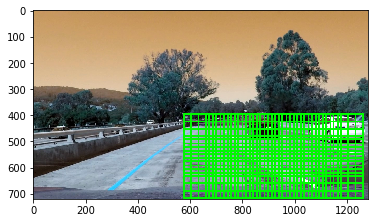

In [25]:
X_Range=(int(test_img.shape[1]*0.45),test_img.shape[1])
Y_Range=(int(test_img.shape[0]*0.55),int(test_img.shape[0]*0.96))
window_size=(96,96)

boxes=slide_window(test_img,x_start_stop=X_Range,y_start_stop=Y_Range,
                   xy_window=window_size,xy_overlap=(0.3, 0.3))
op=draw(test_img,boxes)
plt.imshow(op)

### Detecting Objects

In [26]:
# To get the box co-ordinates of images with car
def search_engine(input_img,clf,window_size=(64,64)):
    
    X_Range=(int(input_img.shape[1]*0.45),input_img.shape[1])
    Y_Range=(int(input_img.shape[0]*0.55),int(input_img.shape[0]*0.96))
    
    boxes=slide_window(input_img,x_start_stop=X_Range,y_start_stop=Y_Range,
                       xy_window=window_size,xy_overlap=(0.3, 0.3))
    result_boxes=[]
    for box in boxes:
        (x1,y1),(x2,y2)=box
        test_box = cv2.resize(input_img[y1:y2,x1:x2], (test_car.shape[0], test_car.shape[1]))      
        curr_features=extract_features(test_box,color_space=Color_Space,
                                       hist_feat=Flag_hist, hog_feat=Flag_hog,spatial_feat=Flag_spatial)
        curr_features=scal.transform([curr_features])
        pred=clf.predict(curr_features)
        if pred==1:
            result_boxes.append(box)
        
    return result_boxes


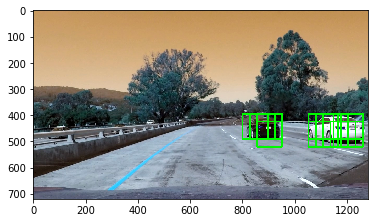

In [27]:
search_window=(96,96)
boxes=search_engine(test_img,clf,window_size=search_window)
plt.imshow(draw(test_img,boxes))

In [28]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

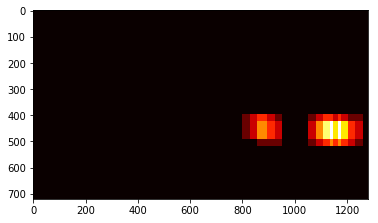

In [29]:
heat_img=add_heat(np.zeros_like(test_img[:,:,0]).astype(np.float),boxes)
plt.imshow(heat_img,cmap='hot')

In [30]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Total number of labels detected :  2


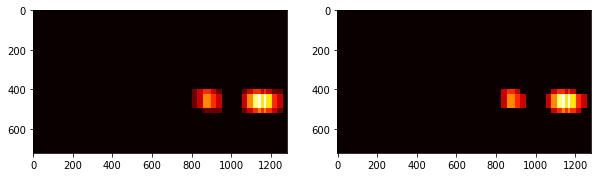

In [31]:
heat_threshold=1
heat_threshold_img=apply_threshold(np.copy(heat_img),threshold=heat_threshold)
fig,ax=plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(heat_img,cmap="hot")
ax[1].imshow(heat_threshold_img,cmap="hot")

from scipy.ndimage.measurements import label
labels = label(heat_threshold_img)
print("Total number of labels detected : ",labels[1])

In [32]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

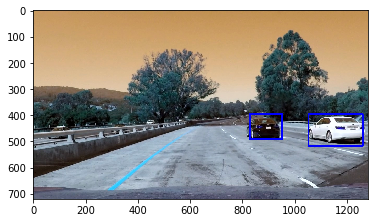

In [33]:
result_boxes=draw_labeled_bboxes(np.copy(test_img),labels)
plt.imshow(result_boxes)

In [34]:
# Don't Change - Trained Parameters
Flag_hist= True
Flag_hog = True
Flag_spatial = True
Color_Space="YUV"

In [36]:
search_window=(96,96)
heat_threshold=1
from collections import deque
history=deque(maxlen=10)

In [40]:
from scipy.ndimage.measurements import label

def update_frame(input_frame):
    # Color Conversion
    input_frame=cv2.cvtColor(input_frame,cv2.COLOR_RGB2BGR)
    
    boxes=[]
    boxes=search_engine(input_frame,clf,window_size=search_window)
    
    heat_img=add_heat(np.zeros_like(input_frame[:,:,0]).astype(np.float),boxes)
    
    history.append(heat_img)
    avg_img=np.sum(list(history),axis=0)
    if (len(history)>=10):
        max_thereshold=heat_threshold*4
        heat_threshold_img=apply_threshold(np.copy(avg_img),threshold=max_thereshold)
    else:
        heat_threshold_img=apply_threshold(np.copy(heat_img),threshold=heat_threshold)
        #return input_frame,boxes,heat_img
    labels = label(heat_threshold_img)
    
    result_frame=cv2.cvtColor(draw_labeled_bboxes(np.copy(input_frame),labels),cv2.COLOR_BGR2RGB)
    
    #return result_frame,boxes,heat_img,labels    # Check point 1
    return result_frame

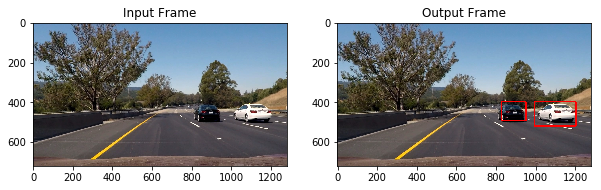

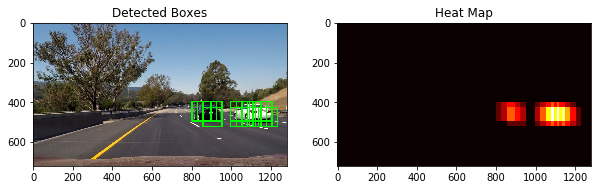

In [38]:
# To verify this code block uncomment check point 1 
history=deque(maxlen=10)
input_frame=mpimg.imread("test_images/test6.jpg")
output,boxes,heat,lab=update_frame(input_frame)
#output=update_frame(input_frame)
fig,ax=plt.subplots(1,2,figsize=(10,10))
ax[0].set_title("Input Frame")
ax[0].imshow(input_frame)
ax[1].set_title("Output Frame")
ax[1].imshow(output)
fig,ax=plt.subplots(1,2,figsize=(10,10))
ax[0].set_title("Detected Boxes")
ax[0].imshow(draw(input_frame,boxes))
ax[1].set_title("Heat Map")
ax[1].imshow(heat,cmap="hot")

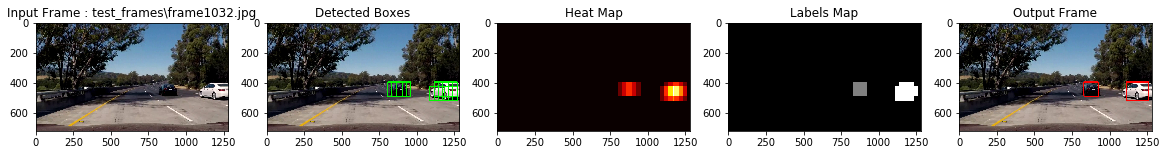

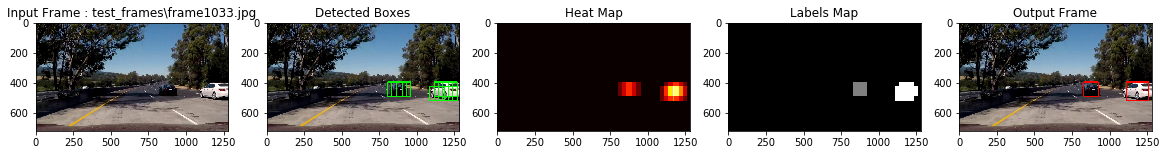

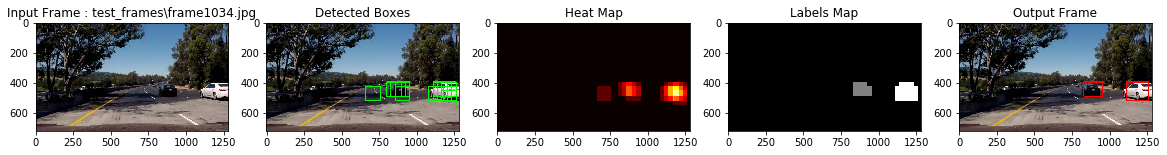

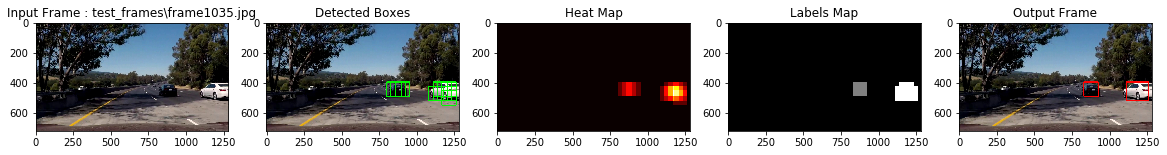

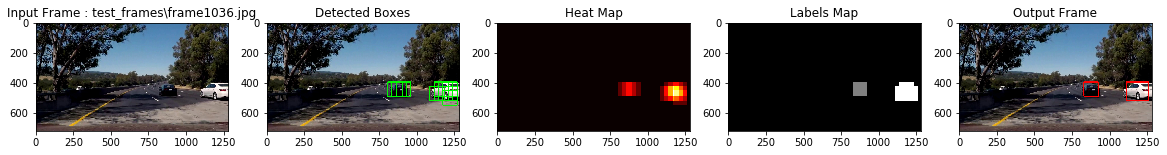

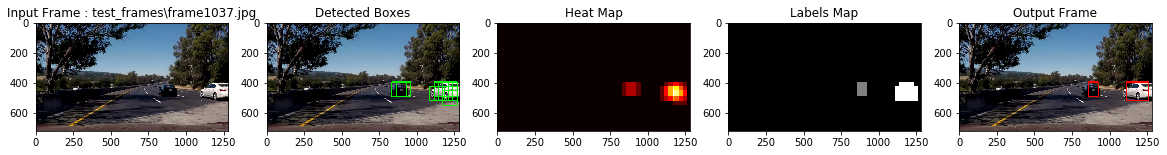

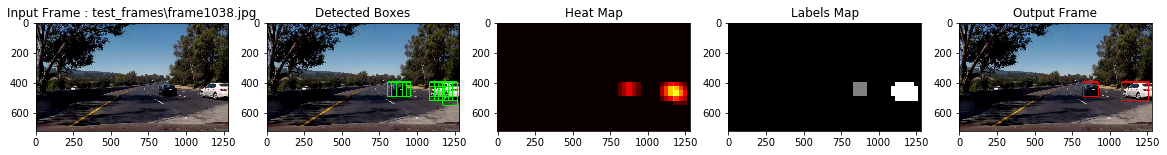

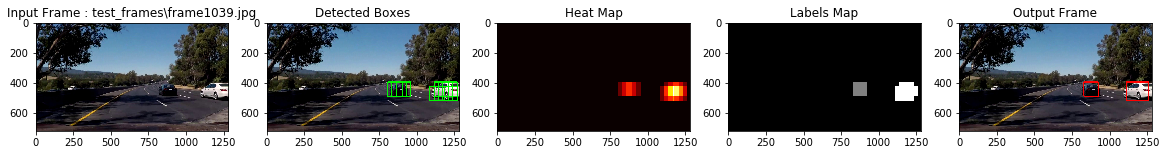

In [39]:
# To verify this code block uncomment check point 1 
sample_frame=glob.glob("test_frames/*.jpg")
for img_name in sample_frame:
    history=deque(maxlen=10)
    input_frame=mpimg.imread(img_name)
    output,boxes,heat,lab=update_frame(input_frame)
    #output=update_frame(input_frame)
    fig,ax=plt.subplots(1,5,figsize=(20,20))
    ax[0].set_title("Input Frame : "+img_name)
    ax[0].imshow(input_frame)
    ax[1].set_title("Detected Boxes")
    ax[1].imshow(draw(input_frame,boxes))
    ax[2].set_title("Heat Map")
    ax[2].imshow(heat,cmap="hot")
    ax[3].set_title("Labels Map")
    ax[3].imshow(lab[0],cmap="gray")
    ax[4].set_title("Output Frame")
    ax[4].imshow(output)  
    

In [41]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [42]:
history=deque(maxlen=10)
white_output = 'test_videos_output/test_video.mp4'
clip1 = VideoFileClip("test_videos/test_video.mp4")
white_clip = clip1.fl_image(update_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:27<00:02,  2.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

Wall time: 1min 30s


In [43]:
history=deque(maxlen=10)
white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(update_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [49:40<00:02,  2.48s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 49min 42s


## Output Video

<video width="920" height="340" controls src="test_videos_output/project_video.mp4" />